In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd

src_path = Path(
    "/Users/pszyc/Library/CloudStorage/GoogleDrive-przemek.7678@gmail.com/My Drive/Studia/Ogniska/"
)

data_files = list(src_path.rglob("00*"))

data_files = [path for path in data_files if (path / "nuclei_mask.npy").exists()]
print(len(data_files))

676


In [9]:
data_file = "NHDF/NHDF_8h PI/IR 4Gy_8h PI/0003"
cloud_path = Path(
    "/Users/pszyc/Library/CloudStorage/GoogleDrive-przemek.7678@gmail.com/My Drive/Studia/Ogniska/"
)
local_path = Path(
    "/Users/pszyc/Code/Science/OgniskaNaprawcze/confocal/DeepFoci/data"
)

(1010, 1362, 50)
(48, 505, 681)
Aligned DAPI shape: (48, 505, 681)
Original mask shape: (48, 505, 681)


/var/folders/4q/tfzvg1g50hd89pj_w0mm6tn40000gn/T/ipykernel_92803/3291859730.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_lbl = cm.get_cmap("nipy_spectral")


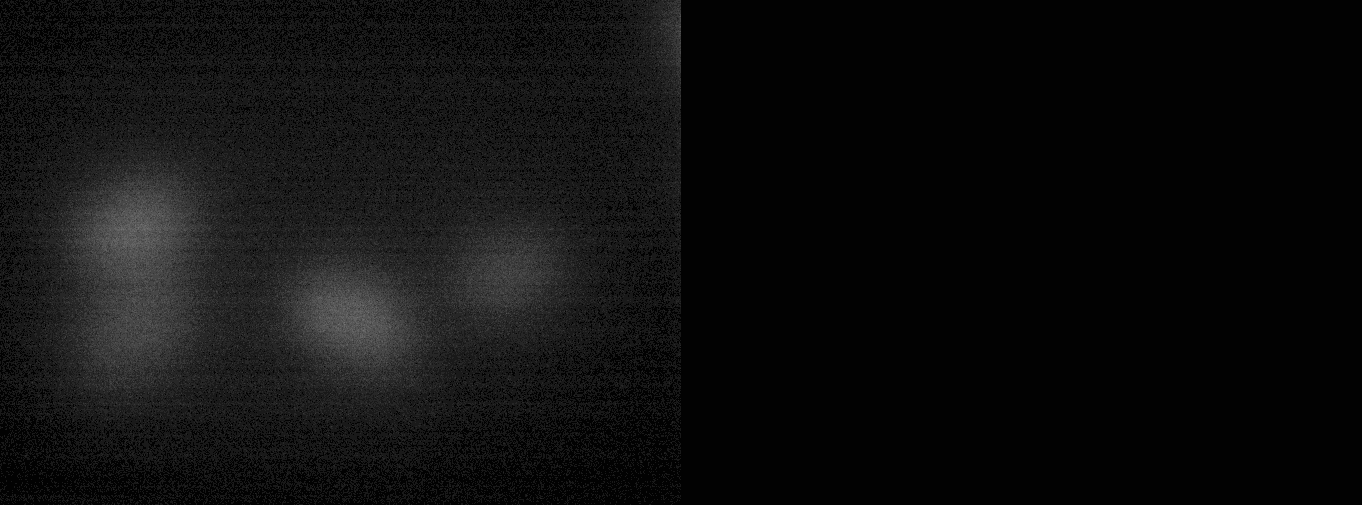

In [18]:
# Create side-by-side GIF comparing DAPI and nuclei mask in the selected folder
from pathlib import Path
import numpy as np
from tifffile import imread
import imageio.v2 as imageio
import matplotlib.cm as cm
from skimage.transform import resize


data_selected = data_files[0]

dapi_path = Path(cloud_path) / data_file / "data_DAPI.tif"
mask_path = Path(local_path) / data_file / "nuclei_mask.npy"

out_path = Path(".") / "mask_vs_dapi.gif"

dapi = imread(str(dapi_path))
mask = np.load(str(mask_path))

print(dapi.shape)
print(mask.shape)
# (1010, 1362, 50)
# (48, 505, 681)

# Rescale DAPI to match mask dimensions
dapi_rescaled = resize(dapi, (mask.shape[1], mask.shape[2], mask.shape[0]), order=1, preserve_range=True, anti_aliasing=True).astype(dapi.dtype)

# Align dimensions
dapi_aligned = np.transpose(dapi_rescaled, (2, 0, 1))

# Verify the new shapes
print("Aligned DAPI shape:", dapi_aligned.shape)
print("Original mask shape:", mask.shape)

vmax_lbl = float(np.max(mask))
if vmax_lbl <= 0:
    vmax_lbl = 1.0
cmap_lbl = cm.get_cmap("nipy_spectral")

dapi_aligned = dapi_aligned.astype(np.float32)
p1, p99 = np.percentile(dapi_aligned, [1, 99])
if p99 <= p1:
    p1 = float(np.min(dapi_aligned))
    p99 = float(np.max(dapi_aligned) if np.max(dapi_aligned) > np.min(dapi_aligned) else np.min(dapi_aligned) + 1.0)

frames = []
for z in range(mask.shape[0]):
    sl0 = dapi_aligned[z, :, :]
    sl0 = (sl0 - p1) / (p99 - p1)
    sl0 = np.clip(sl0, 0, 1)
    gray = (sl0 * 255).astype(np.uint8)
    left_rgba = np.stack([gray, gray, gray, np.full_like(gray, 255)], axis=2)

    sl1 = (mask[z, :, :].astype(np.float32) / vmax_lbl)
    right_rgba = (cmap_lbl(sl1) * 255).astype(np.uint8)

    frame = np.concatenate([left_rgba, right_rgba], axis=1)
    frames.append(frame)

imageio.mimsave(str(out_path), frames, duration=0.08)
display(Image(filename=str(out_path)))

# Run

In [24]:
from tqdm import tqdm
import numpy as np
import pandas as pd

rows = []

for data_selected in tqdm(data_files):
    image_info = "/".join(str(data_selected).split("/")[-3:])
    mask_path = data_selected / "nuclei_mask.npy"

    # memory-map avoids loading full copy into RAM
    mask = np.load(mask_path, mmap_mode="r")

    # FAST for integer labels (typical segmentation masks)
    counts = np.bincount(mask.ravel())
    labels = np.flatnonzero(counts)      # labels that exist
    vals = counts[labels]

    # skip background label 0 if needed
    keep = labels != 0
    labels = labels[keep]
    vals = vals[keep]

    rows.extend(
        {"image_info": image_info, "label": int(l), "count": int(c)}
        for l, c in zip(labels, vals)
    )

counts_df = pd.DataFrame(rows).sort_values(["image_info", "label"]).reset_index(drop=True)

100%|██████████| 676/676 [1:13:03<00:00,  6.48s/it]


In [27]:
counts_df.to_csv("nuclei_mask_counts.csv")

# Analyze

In [60]:
counts_df = pd.read_csv("nuclei_mask_counts.csv")
counts_df['vol'] = counts_df['count'] * 0.065 * 0.065 * 0.3
counts_df['x'] = np.cbrt(counts_df['vol'])

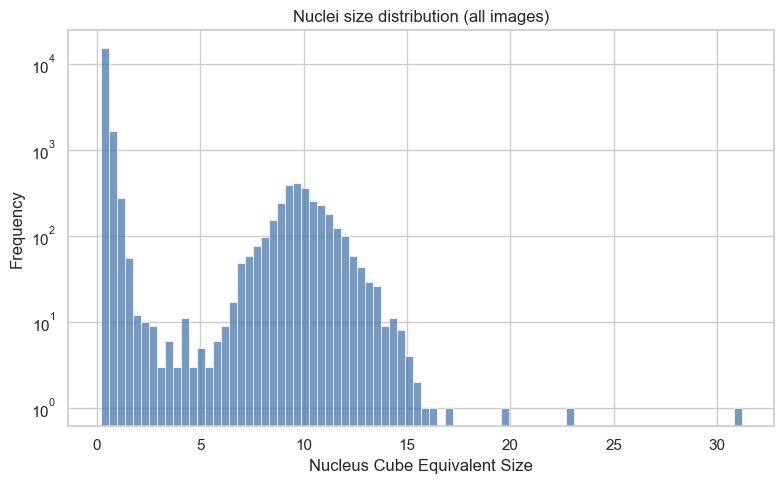

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 5))
sns.histplot(data=counts_df, x='x', bins=80, kde=False, color="#4C78A8")
plt.title("Nuclei size distribution (all images)")
plt.xlabel("Nucleus Cube Equivalent Size")
plt.ylabel("Frequency")
plt.yscale("log")  # log count axis
plt.tight_layout()
plt.show()

In [67]:
counts_df = counts_df[(counts_df['x'] >= 4) & (counts_df['x'] <= 18)]

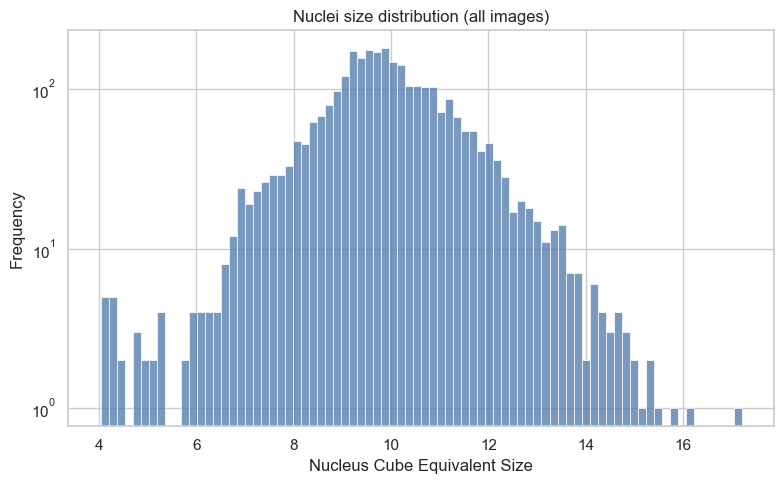

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 5))
sns.histplot(data=counts_df, x='x', bins=80, kde=False, color="#4C78A8")
plt.title("Nuclei size distribution (all images)")
plt.xlabel("Nucleus Cube Equivalent Size")
plt.ylabel("Frequency")
plt.yscale("log")  # log count axis
plt.tight_layout()
plt.show()

In [69]:
cell_line = counts_df['image_info'].apply(lambda x: x.split("_")[0])
cell_line.value_counts()

image_info
U87     1754
NHDF    1213
Name: count, dtype: int64

In [70]:
counts_df['image_info'].nunique()

676

In [71]:
len(counts_df) / counts_df['image_info'].nunique()

4.3890532544378695